In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [1]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-dk6cooj2
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-dk6cooj2
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=7188a75f225df9c3f1f468607632fd0d7d6eba904576d2ec0c7d75cfbf954e2c
  Stored in directory: /tmp/pip-ephem-wheel-cache-pg0nv5at/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [2]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


#Fraktal
###Fraktal to obiekt, którego fragment w powiększeniu wygląda podobnie jak całość. Fraktale możemy spotkać wszędzie, te stworzone naturalnie, czy też przez człowieka. Poniżej jest przedstawiony przykład fraktala Mandelbrota.

#Zbiór Mandelbrota
###Zbiór Mandelbrota - podzbiór płaszczyzny zespolonej, którego brzeg jest jednym z najbardziej znanych fraktali. Na zbiór składają się punkty, dla których ciąg zi jest zdefiniowany wzorem rekurencyjnym:
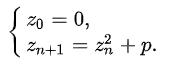
###nie dąży do nieskończoności
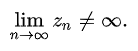
###Jest równoważe z:
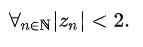
###Czyli alternatywnie zbiór Mandelbrota definiuje się jako punkty, które w rodzinie zbiorów Julii dają zbiory spójne.
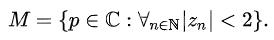


#Wersja CPU

##Opis kodu
##Funkcja główna:
###I część dotyczy zainicjalizowania pomiaru czasu i zmiennych do tego potrzebnych.
    int main(void){
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord( start, 0 );

###II część, przy użyciu funkcji bibliotecznej jest tworzona mapa bitowa o zdefiniowanym rozmiarze, a następnie do funkcji jądra przekazuje wskaźnik na tę mapę.
    DataBlock data;
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM*DIM*4;
    kernel(bitmap);
###Zakończenie pomiaru czasu, wypisanie go i zwolnienie pamięci zmiennych
    cudaEventRecord(stop,0);
    cudaEventSynchronize(stop);
    float elapsedTime;
    cudaEventElapsedTime(&elapsedTime,start,stop);
    printf("Time to generate: %3.1f ms\n",elapsedTime);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);
###Wywołanie funkcji zapisania do pliku danych RGB interesującego nas fraktala.
    save_to_file(bitmap);}

##Funkcja kernel:
###Przegląda iteracyjnie (za pomocą dwóch pętli) wszystkie punkty, dla których wywoływana jest funkcja mandelbrot(x,y), aby sprawdzić, czy należą one do zbioru. Będąc w zbiorze, punkt otrzyma kolor zielony, w innym wypadku czarny.
    void kernel(unsigned char *ptr){
    for(int y=0; y<DIM; y++){
    for(int x=0; x<DIM; x++){
    int offset = x+y*DIM;
    int mandelValue = mandelbrot(x,y);
    ptr[offset*4+0] = 0;
    ptr[offset*4+1] = 255 * mandelValue;
    ptr[offset*4+2] = 155 * mandelValue;
    }}}

##Funkcja mandelbrot:
###Sprawdza przynależność każdego punktu do podzbioru płaszczyzny zespolonej. Jeśli należy, to zwraca 1, jak nie, to wartość wynosi 0.
    int mandelbrot(int x, int y){
    const float scale = 1.5;
    float jx = scale * (float)(DIM/2-x) / (DIM/2);
    float jy = scale * (float)(DIM/2-y) / (DIM/2);
    cuComplex p(jx, jy);
    cuComplex a(0, 0);
    int i = 0;
    for (i = 0; i < 200; i++) {
    a = a * a + p;
    if (a.magnitude2()>1000) 
    return 0;
    }
    return 1;}

##Zapisywanie fraktala
###Funkcja do wypisania wartości RGB, oraz funkcja do zapisu w pliku txt.
    struct DataBlock{
    unsigned char *dev_bitmap;};

    void wypisz_RGB_fraktal(unsigned char *ptr){
    for(int y=0; y<DIM; y++){
    for(int x=0; x<DIM; x++){
    int offset = x+y*DIM;
    printf("%d,%d,%d ", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);}
    }}

    void save_to_file(unsigned char *ptr){
    FILE *fp=fopen("Fraktal_CPU.txt","w");
    fprintf(fp, "%d %d\n", DIM, DIM);
    for(int y=0; y<DIM; y++){
    for(int x=0; x<DIM; x++){
    int offset=x+y*DIM;
    fprintf(fp, "%d,%d,%d ", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);}
    }
    fclose(fp);}

##cuComplex
###Odpowiada za definicję liczb potrzebnych do liczby zespolonej.
    struct cuComplex{
    float r;
    float i;
    cuComplex(float a,float b):r(a),i(b){}
    float magnitude2(void){ return r*r+i*i;}
    cuComplex operator*(const cuComplex &a) { return cuComplex(r*a.r-i*a.i, i*a.r+r*a.i);}
    cuComplex operator+(const cuComplex &a) { return cuComplex(r+a.r, i+a.i);}};

#Pełen kod dla CPU

In [6]:
%%cu
#include <stdio.h>
#define DIM 1000

struct cuComplex{
    float r;
    float i;
    cuComplex(float a,float b):r(a),i(b){}
    float magnitude2(void){ return r*r+i*i;}
    cuComplex operator*(const cuComplex &a) { return cuComplex(r*a.r-i*a.i, i*a.r+r*a.i);}
    cuComplex operator+(const cuComplex &a) { return cuComplex(r+a.r, i+a.i);}
};

int mandelbrot(int x, int y){
    const float scale = 1.5;
    float jx = scale * (float)(DIM/2-x) / (DIM/2);
    float jy = scale * (float)(DIM/2-y) / (DIM/2);
    cuComplex p(jx, jy);
    cuComplex a(0, 0);
    int i = 0;
    for (i = 0; i < 200; i++) {
        a = a * a + p;
        if (a.magnitude2()>1000) 
        return 0;
    }
    return 1;
}

void kernel(unsigned char *ptr){
    for(int y=0; y<DIM; y++){
        for(int x=0; x<DIM; x++){
            int offset = x+y*DIM;
            int mandelValue = mandelbrot(x,y);
            ptr[offset*4+0] = 0;
            ptr[offset*4+1] = 255 * mandelValue;
            ptr[offset*4+2] = 155 * mandelValue;
        }
    }
}

//Zapis fraktala
struct DataBlock{
    unsigned char *dev_bitmap;
};

void wypisz_RGB_fraktal(unsigned char *ptr){
    for(int y=0; y<DIM; y++){
        for(int x=0; x<DIM; x++){
            int offset = x+y*DIM;

            printf("%d,%d,%d ", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
    }
}

void save_to_file(unsigned char *ptr){
    FILE *fp=fopen("Fraktal_CPU.txt","w");
    fprintf(fp, "%d %d\n", DIM, DIM);
    for(int y=0; y<DIM; y++){
        for(int x=0; x<DIM; x++){
            int offset=x+y*DIM;
            fprintf(fp, "%d,%d,%d ", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
    }
    fclose(fp);
}

int main(void){
cudaEvent_t start, stop;
cudaEventCreate(&start);
cudaEventCreate(&stop);
cudaEventRecord( start, 0 );

    DataBlock data;
    unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
    int image_size = DIM*DIM*4;
    kernel(bitmap);

//stop pomiaru czasu i obliczenie jego trwania
cudaEventRecord(stop,0);
cudaEventSynchronize(stop);
float elapsedTime;
cudaEventElapsedTime(&elapsedTime,start,stop);
printf("Time to generate: %3.1f ms\n",elapsedTime);
//wyczyszczenie pamieci
cudaEventDestroy(start);
cudaEventDestroy(stop);

    save_to_file(bitmap);
}

Time to generate: 1306.4 ms



###Time to generate: 1340.4 ms - DIM = 1000
###Time to generate: 136090.8 ms - DIM = 10000

In [5]:
import re
import numpy as np
from PIL import Image
from pathlib import Path

contents = Path('Fraktal_CPU.txt').read_text()

h, w, *pixels = re.findall(r'[0-9]+', contents)

na = np.array(pixels, dtype=np.uint8).reshape((int(h),int(w),3))

Image.fromarray(na).save("wynik_CPU.png")

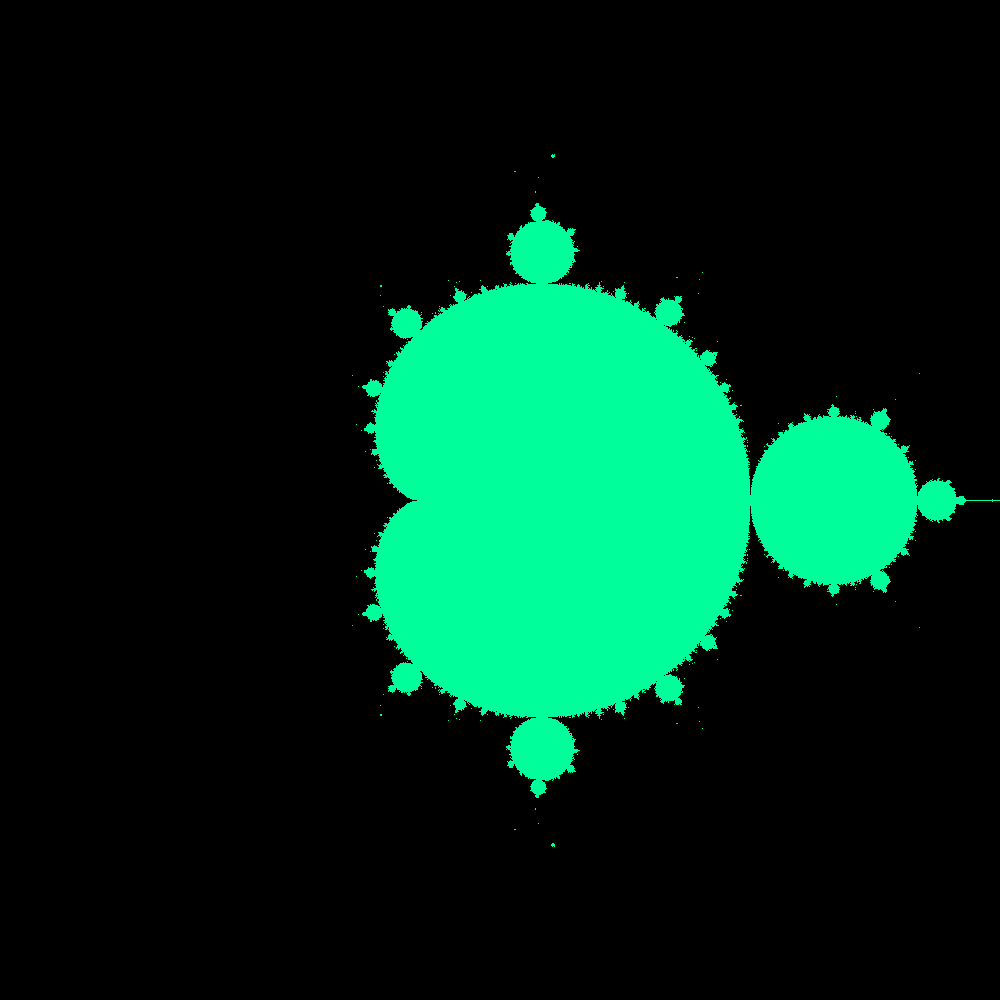

###Fraktal Julii z przerobionego kodu źródłowego
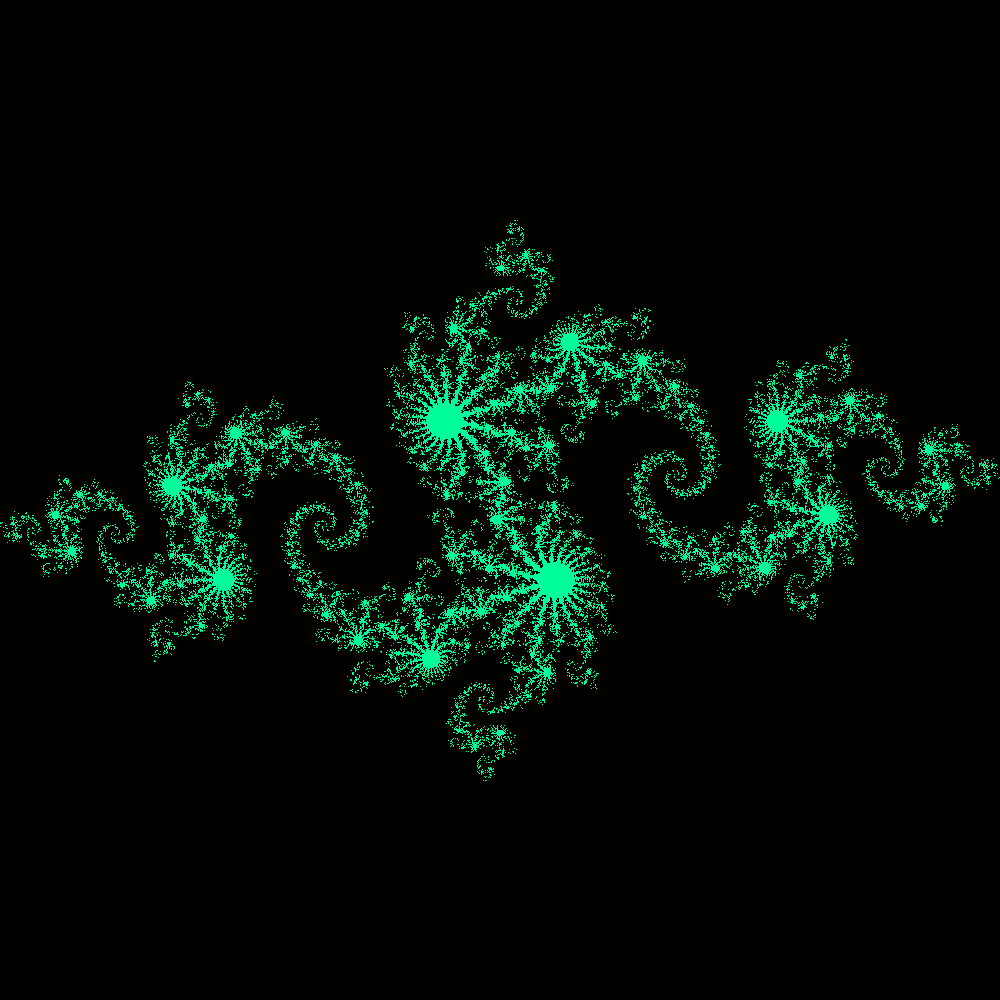

#Wersja GPU
##Różnice CPU - GPU
###Przy GPU dodajemy przy funkcjach __global__ oraz __device__, aby program rzeczywiście był wykonany przy pomocy GPU. Zamiast pętli for, możemy wykorzystać blockIdx. cudaMalloc pozwala przechowywać potrzebne nam dane. dim3 grid(DIM,DIM) tworzy kopie funkcji dla każdego ważnego punktu indeksowaniem dwuwymiarowym. kernel<<<grid,1>>>(dev_bitmap) przekazuje zmienną grid do systemu wykonawczego.

In [42]:
%%cu
#include <stdio.h>
#define DIM 1000

struct cuComplex{
    float r;
    float i;
    
    __device__ cuComplex(float a, float b):r(a),i(b){}
    __device__ float magnitude2(void){ return r*r+i*i;}
    __device__ cuComplex operator*(const cuComplex &a) { return cuComplex(r*a.r-i*a.i, i*a.r+r*a.i);}
    __device__ cuComplex operator+(const cuComplex &a) { return cuComplex(r+a.r, i+a.i);}
};
__device__ int mandelbrot(int x, int y) {
    const float scale = 1.5;
    float jx=scale*(float)(DIM/2-x)/(DIM/2);
    float jy=scale*(float)(DIM/2-y)/(DIM/2);
    cuComplex p(jx, jy);
    cuComplex a(0, 0);
    int i = 0;
    for (i = 0; i < 200; i++) {
        a = a * a + p;
        if (a.magnitude2()>1000) 
        return 0;
    }
    return 1;
}

__global__ void kernel( unsigned char *ptr ) {
// Odwzorowanie z blockldx na współrzędne piksela
int x = blockIdx.x;
int y = blockIdx.y;
int offset = x + y * gridDim.x;
// Obliczenie wartości dla tego punktu
int mandelValue = mandelbrot ( x, y );
ptr[offset*4 + 0] = 255 * mandelValue;
ptr[offset*4 + 1] = 0;
ptr[offset*4 +2] = 255 * mandelValue;
}

//Zapis fraktala
struct DataBlock{
    unsigned char *dev_bitmap;
};

void wypisz_RGB_fraktal(unsigned char *ptr){
    for(int y=0; y<DIM; y++){
        for(int x=0; x<DIM; x++){
            int offset = x+y*DIM;

            printf("%d, %d, %d ", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
    }
}

void save_to_file(unsigned char *ptr){
    FILE *fp=fopen("Fraktal_GPU.txt","w");
    fprintf(fp, "%d %d\n", DIM, DIM);
    for(int y=0; y<DIM; y++){
        for(int x=0; x<DIM; x++){
            int offset=x+y*DIM;
            fprintf(fp, "%d, %d, %d ", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
        }
    }
    fclose(fp);
}

int main(void){
cudaEvent_t start, stop;
cudaEventCreate(&start);
cudaEventCreate(&stop);
cudaEventRecord( start, 0 );


DataBlock data;
unsigned char *bitmap = (unsigned char*)malloc(DIM*DIM*4*sizeof(unsigned char));
int image_size = DIM*DIM*4;
unsigned char *dev_bitmap;
cudaMalloc((void**)&dev_bitmap, image_size);
data.dev_bitmap=dev_bitmap;
dim3 grid(DIM,DIM);
kernel<<<grid,1>>>(dev_bitmap);
cudaMemcpy(bitmap,dev_bitmap,image_size,cudaMemcpyDeviceToHost);

//stop pomiaru czasu i obliczenie jego trwania
cudaEventRecord(stop,0);
cudaEventSynchronize(stop);
float elapsedTime;
cudaEventElapsedTime(&elapsedTime,start,stop);
printf("Time to generate: %3.1f ms\n",elapsedTime);
//wyczyszczenie pamieci
cudaEventDestroy(start);
cudaEventDestroy(stop);

cudaFree(dev_bitmap);
save_to_file (bitmap);
}


Time to generate: 11.3 ms



###Time to generate: 11.1 ms - DIM = 1000
###Time to generate: 780.8 ms - DIM = 10000

In [6]:
import re
import numpy as np
from PIL import Image
from pathlib import Path

contents = Path('Fraktal_GPU.txt').read_text()

h, w, *pixels = re.findall(r'[0-9]+', contents)

na = np.array(pixels, dtype=np.uint8).reshape((int(h),int(w),3))

Image.fromarray(na).save("wynik_GPU.png")

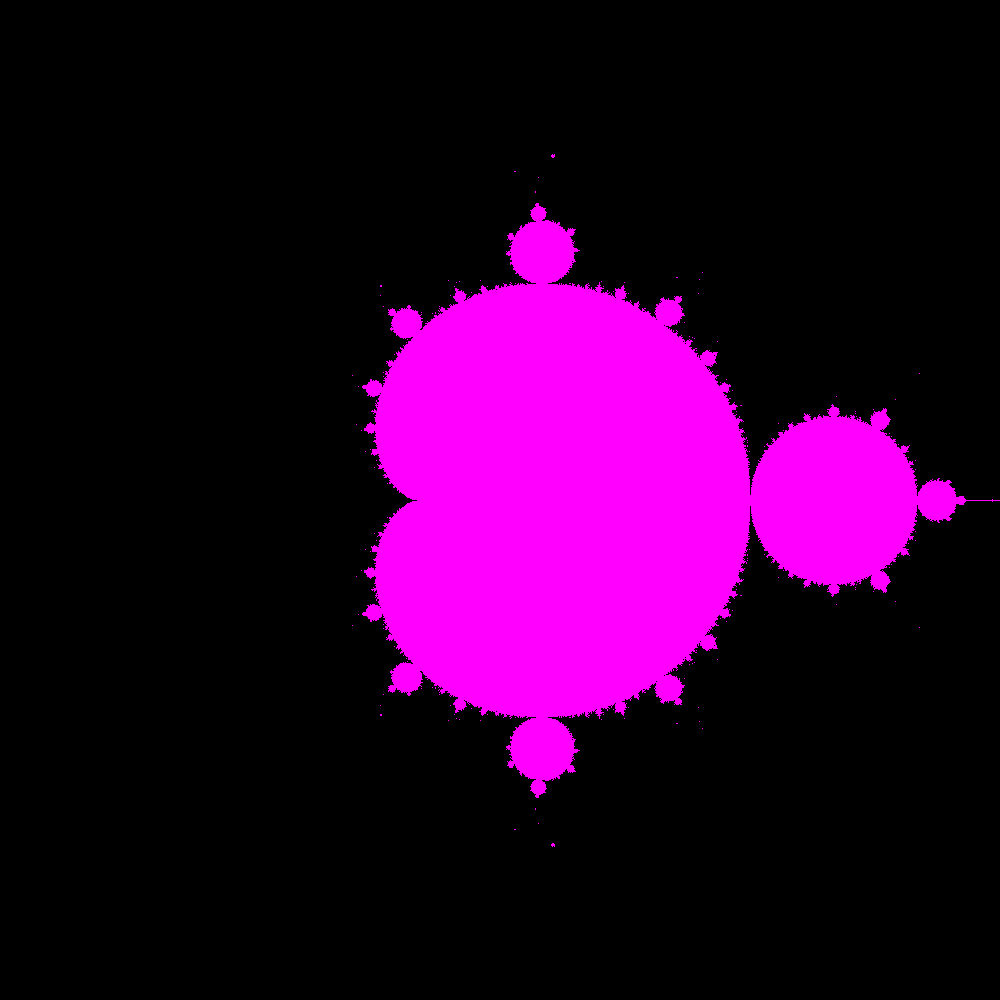

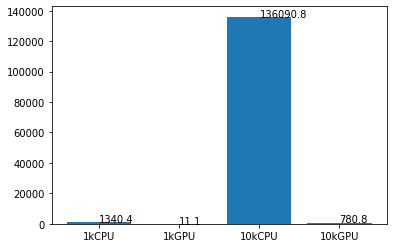

In [41]:
import matplotlib.pyplot as plt
import numpy as np
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])
x = np.array(["1kCPU", "1kGPU", "10kCPU", "10kGPU"])
y = np.array([1340.4 , 11.1, 136090.8, 780.8])
z = y
plt.bar(x,y,0.8)
addlabels(x, y)
plt.show()




#Podsumowanie
###Dla DIM = 1000 opcja GPU poradziła sobie 120 razy szybciej, a dla DIM = 10000 CPU przetwarzało program 174 razy dłużej.
###Różnice są zauważalne. Niestety w obecnej sytuacji nie byłem w stanie przeprowadzić prób dla sprzętu w wersji CPU.